*   [Google Colaboratory를 이용해 Machine Learning 을 해보자!](https://medium.com/@jjeaby/colaboratory-%EC%9D%98-gpu-%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%B4-deep-learning-%EC%9D%84-%ED%95%B4%EB%B3%B4%EC%9E%90-79e12e6ed3b0)

In [0]:
# !pip install scikit-learn==0.19.1
# !pip install scikit-learn>=0.20

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
from sklearn.preprocessing import OneHotEncoder

출처: [머신러닝 프로젝트 실행 - 1](http://cyan91.tistory.com/14?category=230402)



1.   **문제를 정의하고 전체 그림 바라보기 **

2.   **데이터 얻기**

3.   인사이틀 찾기 위해 데이터 탐색하기

4.   기본 데이터 패턴을 머신러닝 알고리즘에 더 잘 노출할 수 있도록 데이터 준비하기

5.   다양한 모델을 탐색하고 그 중 가장 좋은 모델을 찾기

6.   모델을 알맞게 튜닝하고 멋진 솔루션으로  통합하기

7.   시스템 런칭, 모니터링과 유지하기


오픈 데이터셋 중에서 가장 인기있는 3곳


*   [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)
*   [Kaggle datasets](https://www.kaggle.com/datasets)
*   [Amazon's AWS datasets](https://registry.opendata.aws/)

StatLib repository의 캘리포니아 집값 데이터셋
이 데이터셋은 1990년의 인구조사 데이타를 기반으로 하고 있다.

## 1. 문제를 정의하고 전체 그림 바라보기


첫번째 해야 할 일은 캘리포니아 인구조사 데이터를 사용해 캘리포니아 집값 모델을 만드는 것입니다. 이 데이터는 캘리포니아의 각 블록그룹에 대한 인구, 중간 소득, 중간 집값 등 같은 매트릭스로 구성되어 있습니다. 블록그룹은 미국 인구조사국이 제공하는 가장 작은 지리적 유닉(블록그룹은 통상 600~3000명의 사람들로 구성)입니다. 우리는 간단히 '지구('districts')라고 부를 것입니다.

그럼 이제 정확하게 이 데이터를 가지고 무엇을 하려고 하는 것인지를 분명히 하는 것으로 시작해야 합니다. 문제를 어떻게 정하는냐에 따라 문제를 정의하고 어떤 알고리즘을 선택해서, 성능을 측정할지가 정해지기 때문입니다.

여기서는 주어진 데이터를 통해 지구별 가격을 예측해서, 어느 곳에 투자하는 것이 이익을 가장 많이 얻을 수 있는지 알아보는 것을 문제로 정했습니다.

그 다음 확인할 사항은 현재 실행되고 있는 해결방안이 어떻게 이루어지고 있는지 파악하는 것입니다.

여기서는 현재 지역별 집값을 전문가들이 직접 측정하고 있다고 합니다 : 지구별 최신정보를 팀이 모으고, 측정을 위해 복잡한 규칙을 적용합니다. 이것은 비용과 시간이 소모되고, 측정값이 훌륭하지도 않습니다.; 통상 에러율이 약 15% 수준입니다. 

이 모든 정보를 가지고 이제 시스템 디자인을 시작합니다.

첫째, 문제에 대한 프레임이 필요합니다: 지도학습, 비지도학습, 또는 강화학습? 분류 업무, 회귀 업무, 또는 그 밖에 다른? 배치학습 또는 온라인 러닝 기술을 사용해야 하는지? 등을 결정해야 합니다.

이것은 분명히 라벨링된 훈련 예제들(각 인스턴스들은 기대되는 아웃풋과 함께 제시, 예를 들어 각 지구의 중간 집값)이 주어진 통상적인 **지도학습** 업무입니다. 게다가, 값을 예측해야 하기 때문에 전형적인** 회귀 업무**입니다. 더 특별하게는, 이 시스템이 다양한 피처들(features)을 사용해서 예측을 만들기 때문에 **다변량 회귀 문제**입니다(지역별 인구, 중간 수익값 등을 사용할 것입니다). 마지막으로 빠르게 변화하는 데이터를 반영할 필요가 없고, 데이터도 메모리에서 처리가 적당할 정도로 적기 때문에, **배치 러닝**을 사용하는 것으로도 충분할 것입니다.

* 데이터가 크다면, 멀티 서버를 통해 배치 러닝 작업을 분할할 수도 있습니다(예를 들어 MapReduce 기술을 사용),  또는 온라인 러닝 기술을 사용할 수도 있습니다.

**다음 단계는 성능 측정을 선택하는 것입니다.** 회귀 문제에 대한 전형적인 성능 측정은 시스템이 만든 예측값들의 에러들에 대한 표준 편차는 측정하는 RMSE(Root Mean Square Error)를 사용합니다. 예를 들어, RMSE가 50,000과 같다는 것은 시스템이 예측한 68%가 실제 50,000에 포함된다는 의미입니다. 그리고 예측값의 95%가 실제 100,000 값들에 포함된다는 것입니다.

RMSE가 일반적으로 회귀 업무에 선호되는 성능 측정이긴 하지만, 몇몇 문맥에서 다른 기능을 사용하는 것을 선호할 수도 있습니다. 예를 들어, 특이값을 갖는 지구가 많이 있다고 가정해 보자. 그러한 경우에, Mean Absolute Error(MAE)를 사용하는 것도 고려해볼 수 있습니다. 

RMSE가 MAE 모두 두 개의 백터값 거리를 측정하는 방법들입니다. 예측 벡터와 타겟값 벡터, 다양한 거리 측정 또는 규칙들이 가능합니다.

**마지막으로, 지금까지 만들어진 가정들을 리스트하고 검증합니다.** 이를 통해 심각한 이슈사항을 찾을 수 있습니다. 예를 들어, 시스템 아웃풋인 각 지구별 값을 정확하게 예측하는 것보다 카테고리(예, 싼, 중간, 비싼)로 가격을 변환해서 처리하는 것이 더 나을 수도 있습니다. 이럴 경우, 이 문제는 회귀 업무가 아니라 , 분류 업무로 재정되어야 할 것입니다. 몇 달 동안 회귀 시스템 구축을 추진한 후에 분류 업무로 처리해야 한다는 말을 듣고 싶지는 않을 것입니다. 그렇기 때문에, 초기에 피드백을 받는 것이 중요합니다.

## 2. 데이터 얻기

머신러닝 코드와 데이터셋을 위한 작업 디렉토리가 필요합니다. 

In [0]:
%config InlineBackend.figure_format = 'retina'

In [0]:
import os
import tarfile
from six.moves import urllib

In [0]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [0]:
# 드라이브 폴더에 있는 future_encoders.py를 업로드 합니다.
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving future_encoders.py to future_encoders.py
User uploaded file "future_encoders.py" with length 60135 bytes


In [0]:
!ls

california.png	future_encoders.py  sample_data


함수 fetch_housing_data()를 불러오면, 작업 디렉토리에 datasets/housing 폴더를 만들고, housing.tgz 파일을 다운로드합니다. 그리고, 이 디렉토리에 housing.tgz 파일을 다운로드합니다. 그리고, 이 디렉토리에 housing.csv 파일을 압축해제합니다.

In [0]:
fetch_housing_data()

In [0]:
!ls -alf datasets/housing

housing.csv  ..  .  housing.tgz


In [0]:
import pandas as pd

In [0]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

위 함수는 모든 데이터를 포함한 pandas 데이타프레임을 불러옵니다.
그 다음에 데이터 구조를 빠르게 살펴봅니다.

In [0]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [0]:
# print(len(list(housing)))
for i,col in enumerate(list(housing)):
    print(i,col)

0 longitude
1 latitude
2 housing_median_age
3 total_rooms
4 total_bedrooms
5 population
6 households
7 median_income
8 median_house_value
9 ocean_proximity


각 열은 하나의 특정 속성을 나타냅니다. 여기에는 10개의 속성들이 있습니다.

In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


이 데이터셋에는 **총 20,640개**의 레코드들이 있습니다. **머신러닝 표준에서는 매우 적은 수의 데이터들입니다. **그러나, 처음 시작하기에는 완벽합니다. 
info()로 확인한 바에 의하면, bedrooms 속성이 20,433개의 non-null 값을 가지고 있습니다. 이것은 207개의 레코들의 값이 없다는 것을 의미합니다. 그리고 모든 속성들이 숫자들입니다. ocean_proximity를 제외하구요. ocean_proximity의 type은 object로 파이썬의 어떤 object라도 담을 수 있습니다. 위 head()를 잘 살펴보았다면, ocean_proximity가 text 속성을 가지고 있다는 것을 알 수 있을 것입니다. 또한 이 컬럼의 값이 반복된다는 것을 알아챘다면, **value_counts()** 메소드를 통해 각 카테고리에 얼마나 많은 값들이 있는지 알아낼 수 있을 것입니다.

In [0]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**describe()** 메소드는 숫자 속성들의 요약을 보여줍니다.

In [0]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


count, mean, min, max 행은 자명합니다. null 값들이 무시된 것을 주의하시기 바랍니다. (예를 들어, total_bedrooms의 count는 20,640이 아니라 20,433입니다). 25%, 50%, 75% 행은 해당 백분위 수를 보여줍니다. 예를 들어 housing_median_age의 25%는 18보다 작다는 것을 알려줍니다. 50%는 29보다, 75%는 37보다 작습니다. 이것은 흔히 25th 백분위(또는  1 분위수), 중앙값, 그리고 75th 백분위(3 분위수)로 불립니다.

지금 다루고 있는 데이터 형태를 느끼기 위한 빠른 다른 방법은 각 숫자 속성에 대한 히스토그램을 그리는 것입니다.

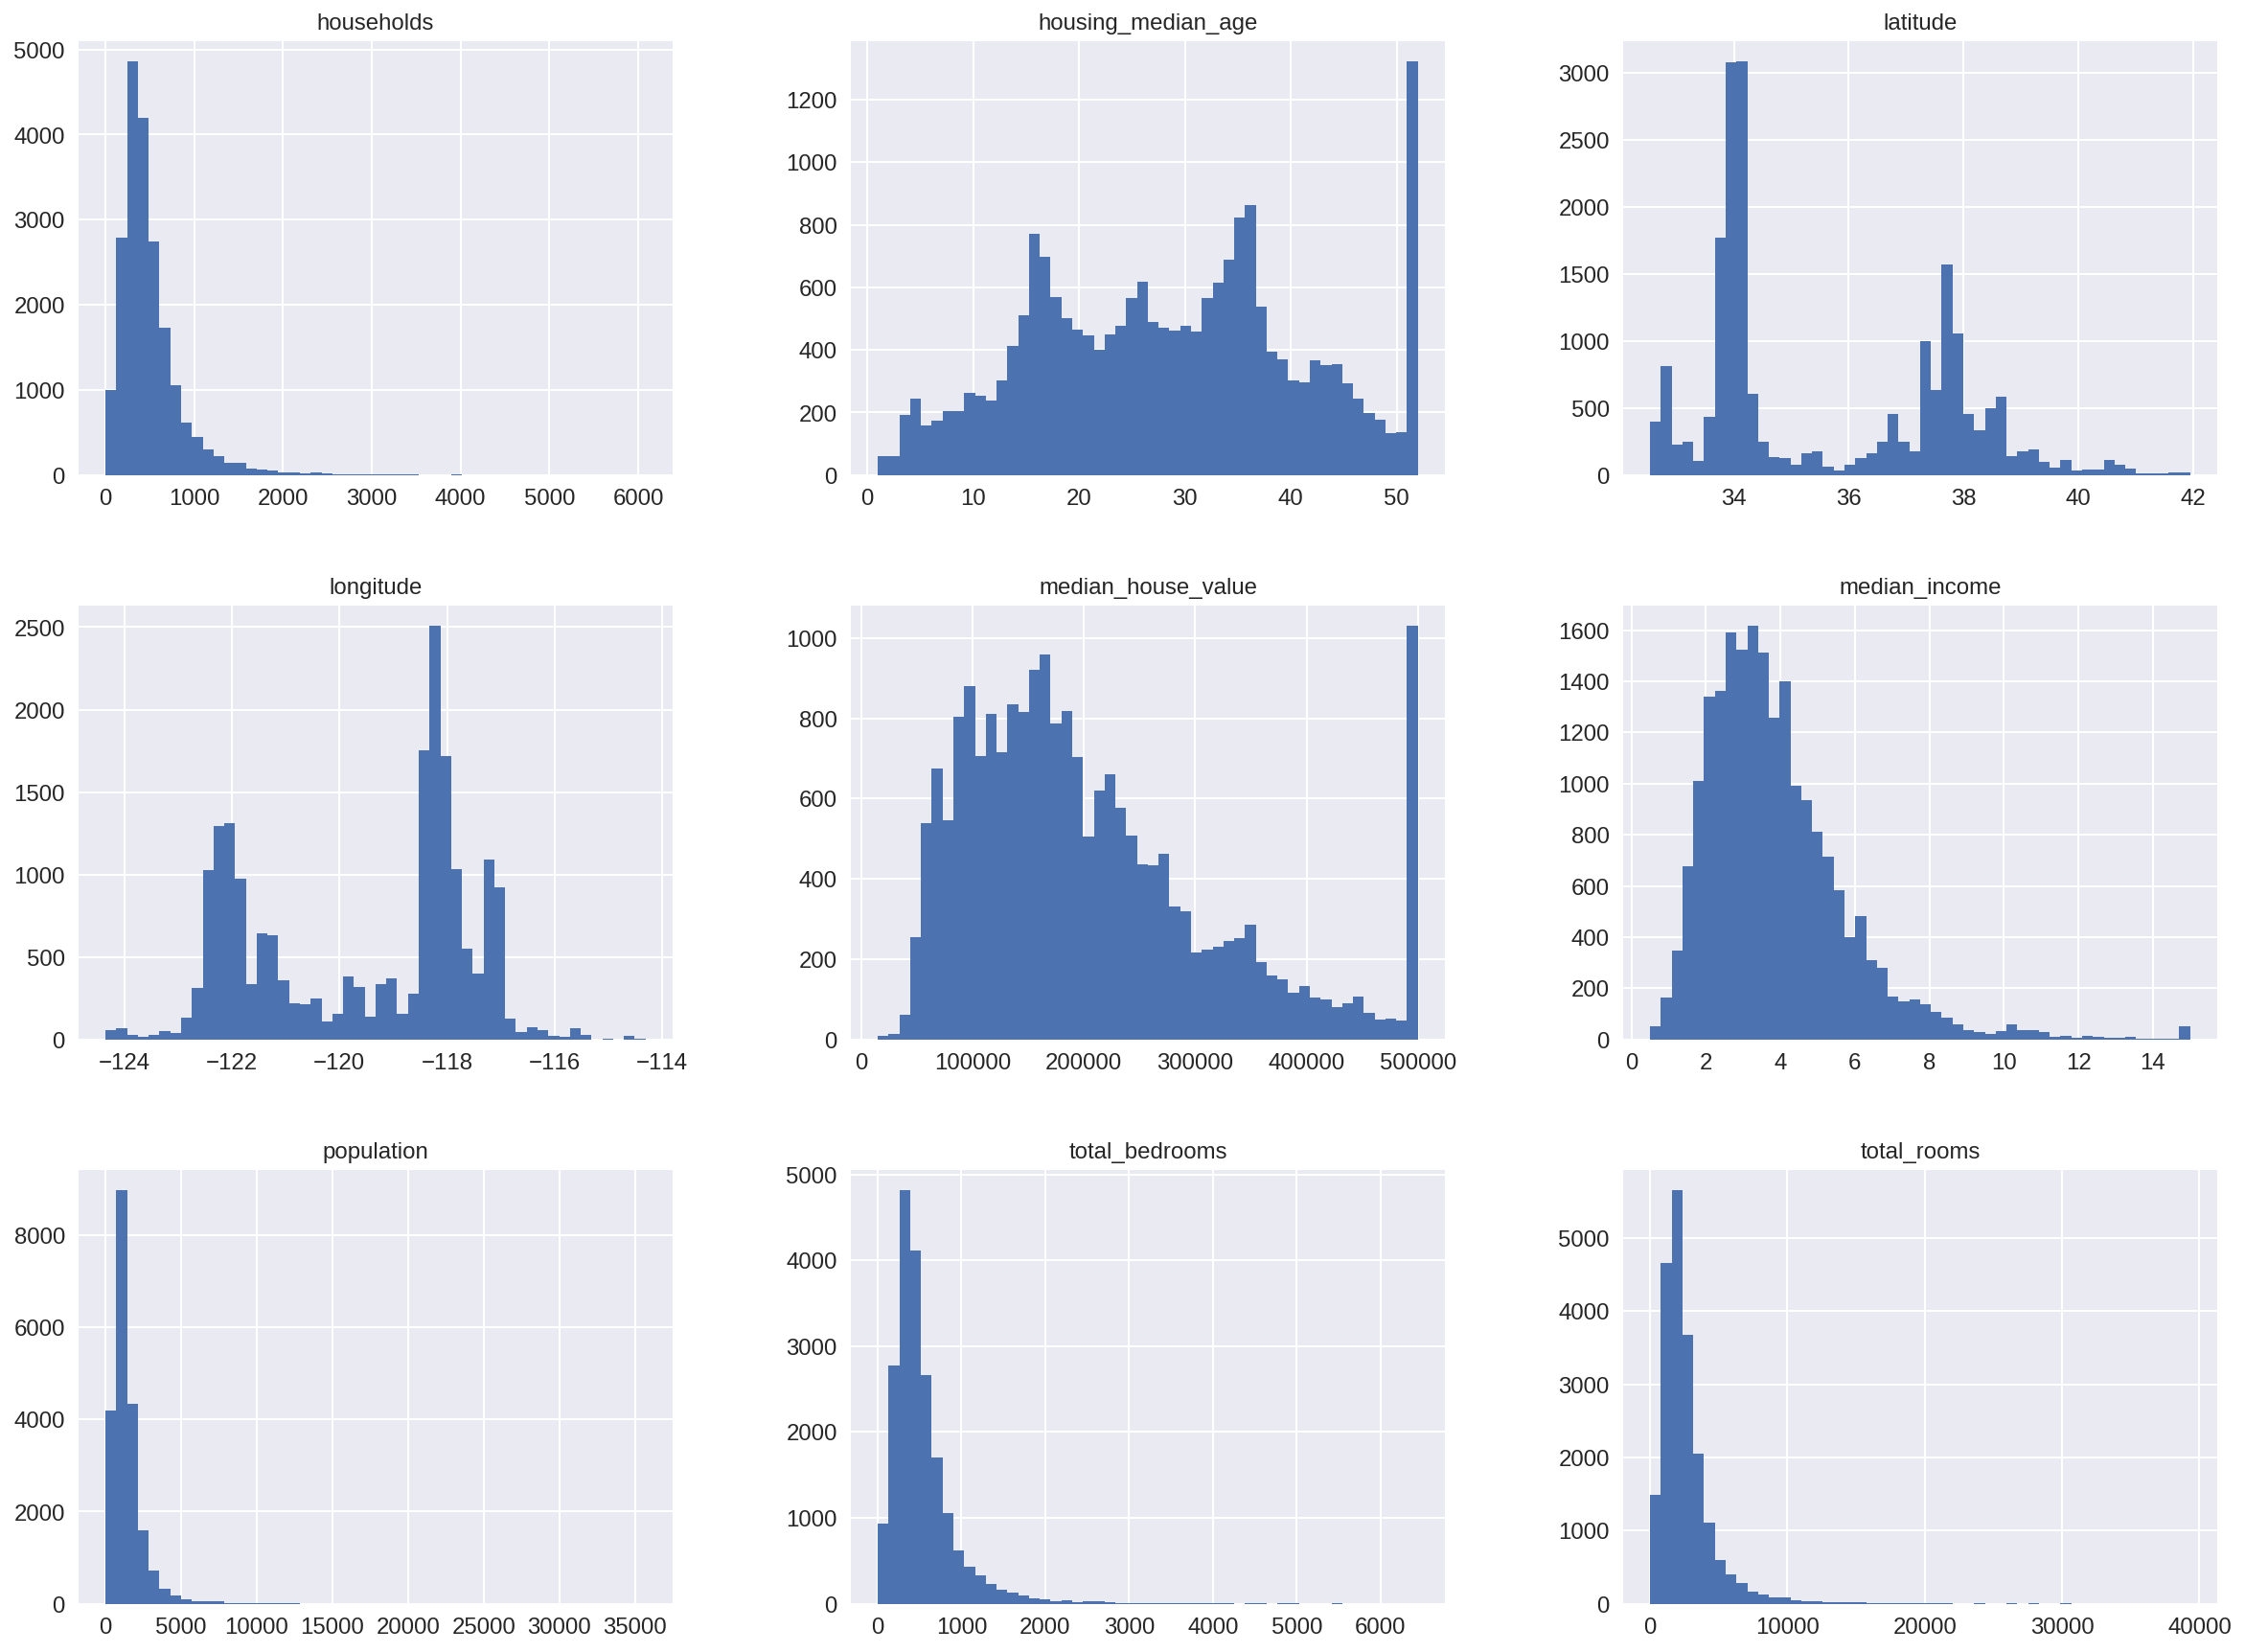

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
# plt.save_fig("attribute_histogram_plots")
plt.show()

위 히스토그램에서, **median_income 속성은 미국달러로 표현된 것처럼 보이지 않습니다.** 머신러닝에서는 보통 전처리된 속성들로 작업합니다. 그래서, 문제가 되지는 않습니다만, 데이터가 어떻게 계산되었는지 파악하려는 노력을 해야만 합니다.
**housing_median_age와 median_house_value값 모두 상한선이 있습니다. 이것이 문제가 될지 안될지 점검하는 것이 필요합니다.**
**많은 히스토그램들의 꼬리가 깁니다. 중앙값보다 오른쪽으로 더 많이 깁니다. 이것은 몇몇 머신러닝 알고리즘에 있어 패턴을 인식하는데 더 어려움을 줄 수 있습니다. 나중에 이들 속성이 종 모양의 분포를 가질 수 있도록 속성들에 변형을 주도록 할 것입니다.**

### 테스트 셋 만들기

이론적으로 테스트 셋을 만드는 것은 매우 간단합니다 : 랜덤하게 몇몇 인스턴스를 선택합니다. 통상 데이터셋의 20%를 선택해서, 따로 설정해둡니다.

In [0]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [0]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


이것이 동작하긴 하지만, 완벽하지는 않습니다. 만약 이 프로그램을 다시 작동시키면, 이것은 다른 테스트 셋을 생성할 것입니다! 하나의 해결책은 처음 작동시에 테스트 셋을 저장하는 것입니다. 다른 옵션은 np.random.permuation()을 학습하기 저너에 랜덤 숫자 제너레이터 씨드를 설정(예를 들어, np.random.seed(42))하는 것입니다. 그러면 항상 동일한 수치들은 생성할 것입니다. 

위 두 개의 해결책은 다음 번 업데이트된 데이터셋을 패치할 때 깨질 것입니다. 일반적인 해결책은 테스트 셋에 가야할 지 말아야 할지를 결정하기 위해 각 인스턴스의 식별자(인스턴스들이 고유하고 불변의 식별자자를 가지고 있다고 가정)를 사용하는 것입니다. 예를 들어, 각 인스턴스의 식별자의 해시를 계산하고, 그 해시의 마지막 바이트만 간직합니다. 그리고 그 값이 51(256의 20%)보다 작거나 같다면 테스트 셋에 일관성을 유지하게 됩니다. 새로운 테스트 셋은 새로운 인스턴스의 20%를 포함할 것입니다. 하지만 이전 트레이닝 셋의 어떤 인스턴스도 포함하지 않습니다. 아래 실행 가능한 코드가 있습니다.

In [0]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [0]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

불행히도, housing 데이타 셋은 식별자 컬럼을 가지고 있지 않습니다. 간단한 해결책은 ID로써 열 인덱스를 사용하는 것입니다.

In [0]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

만약 고유한 식별자로 열 인덱스를 사용한다면, 새로운 데이터가 데이터 셋 마지막에 추가되는 것을 확인하는 것이 필요합니다. 그리고 어떤 열도 삭제되지 않아야 합니다. 이것이 불가능하다면, 고유한 식별자를 만들기 위해 가장 안정적인 피처를 사용하도록 해봐야 할 것입니다. 예를 들어, 지구(district)의 위도와 경도가 수백년 동안 안정된 것으로 보장될 것입니다. 그래서 이 둘을 ID로써 병합할 수 있습니다.

In [0]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

Scikit-Learn은 다양한 방법으로 데이터셋을 여러 개의 서브 셋으로 나누는 함수들을 제공합니다. 가장 간단한 함수가 train_test_split입니다. 앞에서 정의한 split_train_test 함수와 매우 많은 부분이 동일합니다. 

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

지금까지 순수 랜덤 샘플링 메서드를 살펴보았습니다. 이것은 데이터셋이 충분히 크다면(특히 속성들의 수와 비례해서), 일반적으로 훌륭합니다.  그러나 그렇지 않은 경우에는 상당한 샘플링 편차가 발생할 수  있습니다. 설문조사 회사가 1,000명에게 설문을 돌릴 때, 단순히 전화번호부에서 무작위로 1,000명을 뽑지는 않습니다. 예를 드어, 미국 인구는 51.3%의 여성과 48.7%의 남성으로 구성되어 있습니다. 그래서 미국에서 잘 만든 설문조사는 샘플에서 이 비율(513명의 여성과 487명의 남성)을 유지하려고 할 것입니다. 이것은 **층화(stratified) 샘플링**이라 부릅니다. 인구는 지층이라 불리는 균질한 하위 집단으로 나뉘어집니다. 테스트 셋이 전체 모집단을 대표할 수 있돌고 하기 위해 각 계층에서 올바른 숫자의 인스턴스들이 샘플링됩니다. 만약 순수 랜덤 샘플링 메서드를 사용했다면, 49% 여성보다 더 적거나 54% 여성보다 더 많은 편향된 테스트  셋을 샘플링할 확률이 ㅓ12%나 됩니다. 어느 쪽이든, 설문조사 결과가 상당히 편향될 것입니다. 


**전문가들이 중간(median) 집값을 예측하기 위해 중간(median) 소득이 매우 중요한 속성이라고 말했다고 가정해봅시다. 테스트셋이 전체 데이터셋의 다양한 카테고리의 소득들을 대표하는 것이 확실하기를 원할 것입니다. **중간(median) 소득이 연속된 숫자 속성이기 때문에, 최초에 수입 카테고리 속성을 만드는 것이 필요합니다. 중간(median) 소득 히스토그램을 더 자세히 들여다 봅시다.

In [0]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


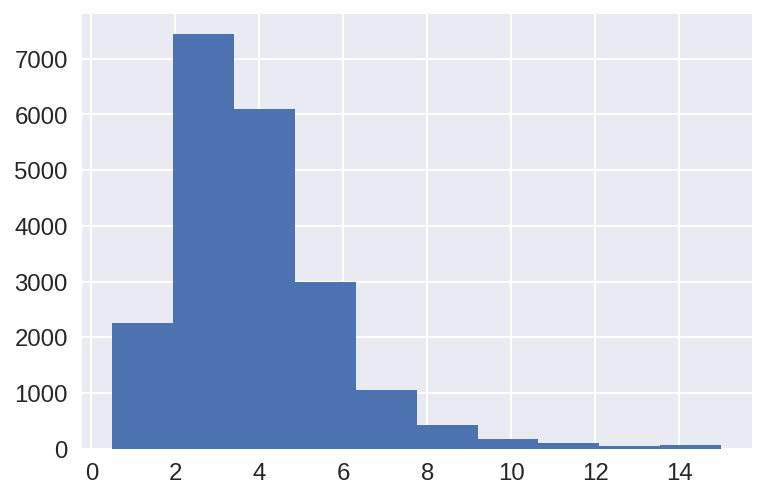

In [0]:
%matplotlib inline
housing["median_income"].hist()

대부분의 중간 소득 값은 2-5 사이입니다. 하지만 몇몇 중간 소득들은 6을 넘습니다. 데이터 집합에 각 계층별 충분한 수의 인스턴스들을 갖는 것이 중요합니다. 그렇지 않으면 지층별 중요성에 대한 추정치가 편향될 수도 있습니다. 
다음 코드는 1.5로 나눈 소득 카테고리 속성을 만듭니다. 그리고 ceil을 사용해 반올림(이산 카테고리를 갖게 됩니다)합니다. 그 다음에 5보다 큰 모든 카테고리를 카테고리 5로 합칩니다.

In [0]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

이제  소득 카테고리에 기반한 층화(stratified) 샘플링을 할 준비가 되었습니다. **Scikit-Learn의 StratifiedShuffleSplit 클래스**를 사용할 수 있습니다.


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

기대한대로 동작하는지 봅시다. 먼저 전체 housing 데이터셋에서 소득 카테고리 비중을 봅시다. 

In [0]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

위와 유사한 코드로 테스트셋의 소득 카테고리 비중을 측정할 수 있습니다. 아래 표에서 전체 데이터셋과 층화(stratified) 샘플링으로 생성된 테스트 셋, 순수 랜덤 샘플링으로 생성된 테스트 셋의 소득 카테코리 비중을 비교할 수 있습니다. 층화(stratified) 샘플링으로 생성된 테스트 셋의 비중이 전체 데이터 셋의 비중과 거의 동일한 것을 알 수 있습니다.

In [0]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [0]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


이제 데이터를 원래 상태로 되돌리기 위해 income_cat 속성을 제거해야 합니다.

In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

테스트 셋을 생성하는 것에 대해서 알아보았습니다. 이 부분은 머신러닝 프로젝트에서 흔히 간과되지만 중요한 부분입니다. 게다가 이들 많은 아이디어들은 앞으로 **교차 검증**을 논의할 때 유용할 것입니다.

## 3. 인사이트를 찾기 위해 데이터를 탐색하기 



먼저, 테스트 셋을 별도로 마련해두었는지 확인하고, 훈련 셋을 탐색해 보도록 합시다. 만약 훈련 셋이 아주 크다면, 쉽고 빠르게 데이터를 다루기 위해 탐색하기 위한 셋을 샘플링하고 싶을지도 모릅니다. 우리 데이터의 경우에는, 훈련 셋이 매우 작기 때문에 전체 셋에서 직접 작업을 할 수 있습니다. 
카피본을 만들어, 훈련 셋에 영향을 주지 않고 작업을 시작해 봅시다.


In [0]:
housing = strat_train_set.copy()

## 지리 데이터를 시각화하기

지리ㅣ 정보(위도와 경도)가 있기 때문에, 데이터를 시각화하기 위해 모든 지구의 산포도를 만들어 보는 것은 좋은 아이디어입니다.

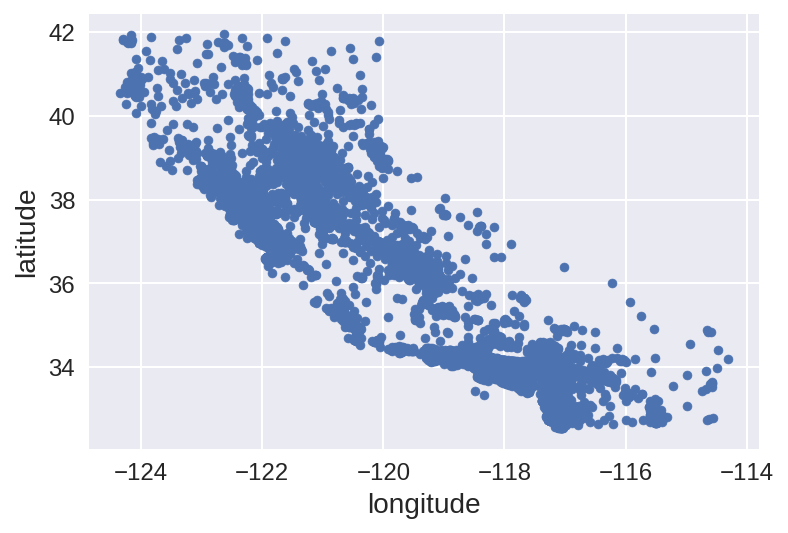

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude")
# save_fig("bad_visualization_plot")

이것은 캘리포니아처럼 보입니다. 하지만, 어떤 특정 패턴을 보기는 어렵습니다. alpha 옵션(투명도)을 0.1로 설정하면 데이터 포인트가 고밀도인 곳이 어느 지역인지 더 쉽게 시각화할 수 있습니다.

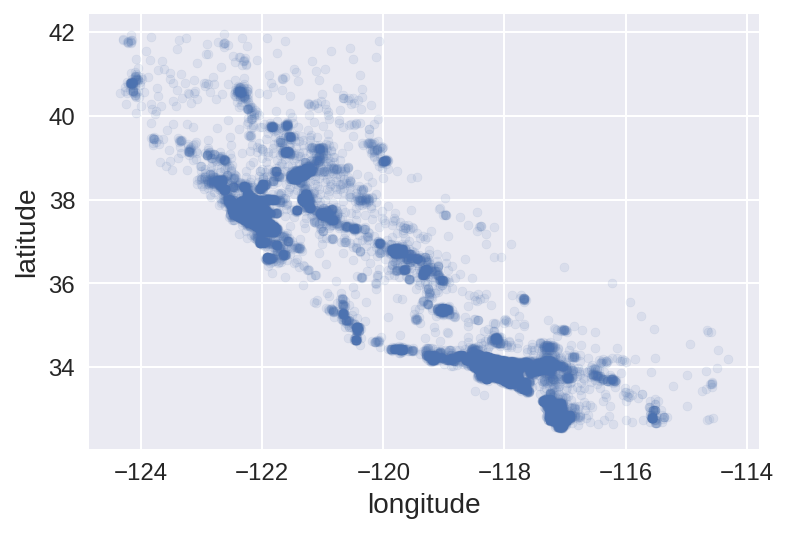

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
# save_fig("better_visualization_plot")

이제 더 좋아 보입니다. 
즉 베이지역과 로스앤젤레스, 샌디에이고 같은 고밀도 지역을 분명하게 구분할 수 있습니다. 샌트럴 밸리 특히 새크라멘토와 프레스노 주변은 상당히 고밀도의 긴 선을 보여주고 있습니다.
일반적으로 우리 두뇌는 그리머에서 얼룩진 패턴을 인식하는데 매우 우수합니다. 하지만 패턴을 눈에 띄게 만들기 위해 시각화 파라미터를 가지고 더 작업이 필요할 수도 있습니다.

각 원의 반경은 지구의 인구수를 나타냅니다. 그리고 색깔은 가격을 나타냅니다. 여기서는 jet(낮은 값은 푸른색, 높은 값은 붉은 색으로 표시)라 불리는 미리 정의된 색깔 맵을 사용할 것입니다. 

[Simple Scatter Plots](https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html)

Notice that the color argument is automatically mapped to a color scale (shown here by the colorbar() command), and that the size argument is given in pixels. In this way, the color and size of points can be used to convey information in the visualization, in order to visualize multidimensional data.

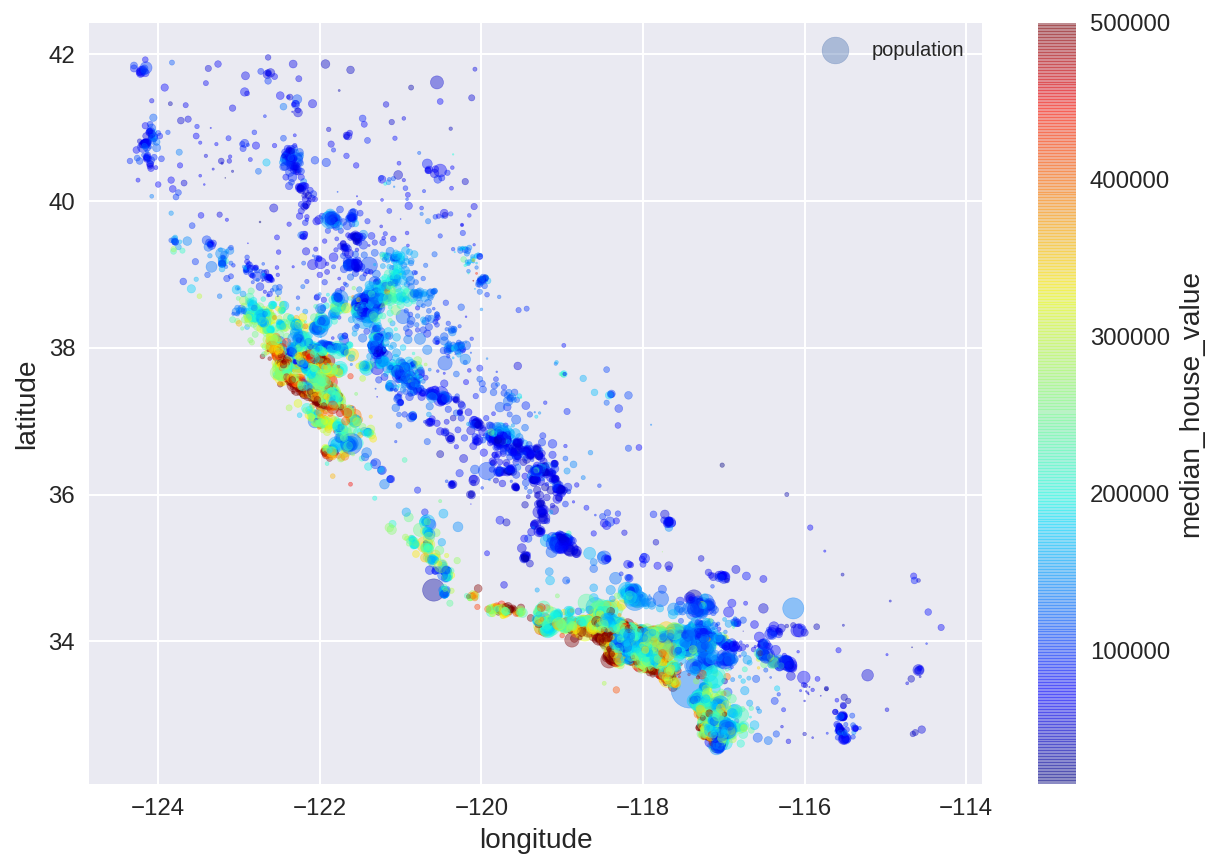

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
# save_fig("housing_prices_scatterplot")

이 이미지는 집값이 위치(예를 들자면, 해안과 가까운) 및 인구 밀도와  매우 밀접한 관계가 있다고 알려줍니다. 아마도 중심 클러스터를 탐지하기 위해 클러스터링 알고리즘을 사용하는 것이 유용할 수도 있습니다. 그리고, 클러스터 센터를 더 근접 측정하기 위해  새로운 피처들(features)을 추가할 수도 있습니다. 해안 근접 속성이 유용할 수 있지만, 북부 캘리포니아의 해안 지구 집값이 높지 않기 때문에, 규칙이 간단하지만은 않습니다.

## 상관관계 찾기

데이터셋이 아주 크지 않기 때문에, 모든 속성 쌍에서 corr() 메소드를 사용해 표준상관계수(Pearson's r이라 불림)를 쉽게 계산할 수 있습니다. 



In [0]:
corr_matrix = housing.corr()

In [0]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


중간 집 값과 각  속성들이 얼마 상관관계가 있는지 보도록 합시다.

In [0]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

상관계수의 범위는 -1에서 1사입니다.
1에 가깝다는 것은 강한 양의 상관관계가 있다는 것을 의미합니다: 예를 들어, 중간 소득이 올라갈 때, 중간 집 값이 올라는 경향이 있습니다. 상관관계가 -1에 가깝다는 것은, 강한 음의 상관관계가 있다는 것을 의미합니다: 위도와 중간 집 값은 작은 음의 상관관계가 있다는 것(예, 북쪽으로 갈수록 집 가격이 약간 낮아지는 경향이 있습니다)을 알 수 있습니다. 마지막으로, 계수가 0에 가깝다는 것은 선형 상관관계가 없다는 것을 의미합니다. 

다음의 이미지들은 수평 및 수직 축 사이의 상관계수에 대한 다양한 플롯을 보여줍니다.

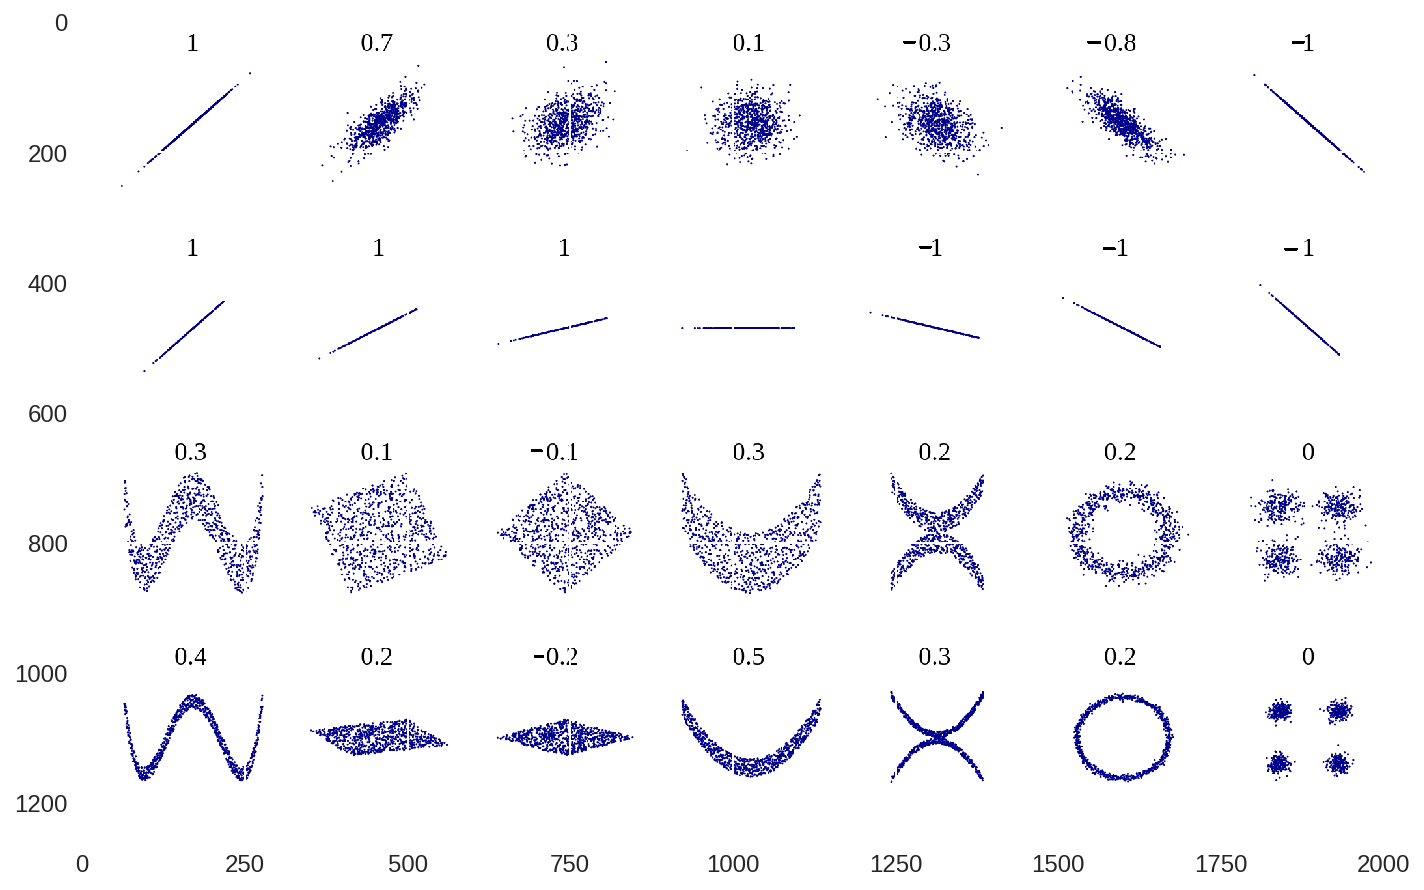

In [0]:
import matplotlib.image as mpimg
fig,ax=plt.subplots(figsize=(10,7))
corr_img=mpimg.imread('https://datascienceschool.net/upfiles/e01bb77e55da4dbc8fb3fd60a707b050.png')
plt.imshow(corr_img)
plt.tight_layout()

In [0]:
list(housing)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

속성들 사이의 상관관계를 점검하는 또 다른 방법은 판다스(Pandas)의 **scattter_matrix 함수**를 사용하는 것입니다. 이 함수는 모든 수치 속성을 모든 다른 수치 속성들에 대비한 플롯을 보여줍니다. 지금 11개의 수치 속성들이 있기 때문에, 121개의 플롯들을 얻게 될 것입니다. 여기서는 중간 집값과 가장 좋은 상관관계를 보여주는 몇가지 속성들에만 집중하도록 합니다.

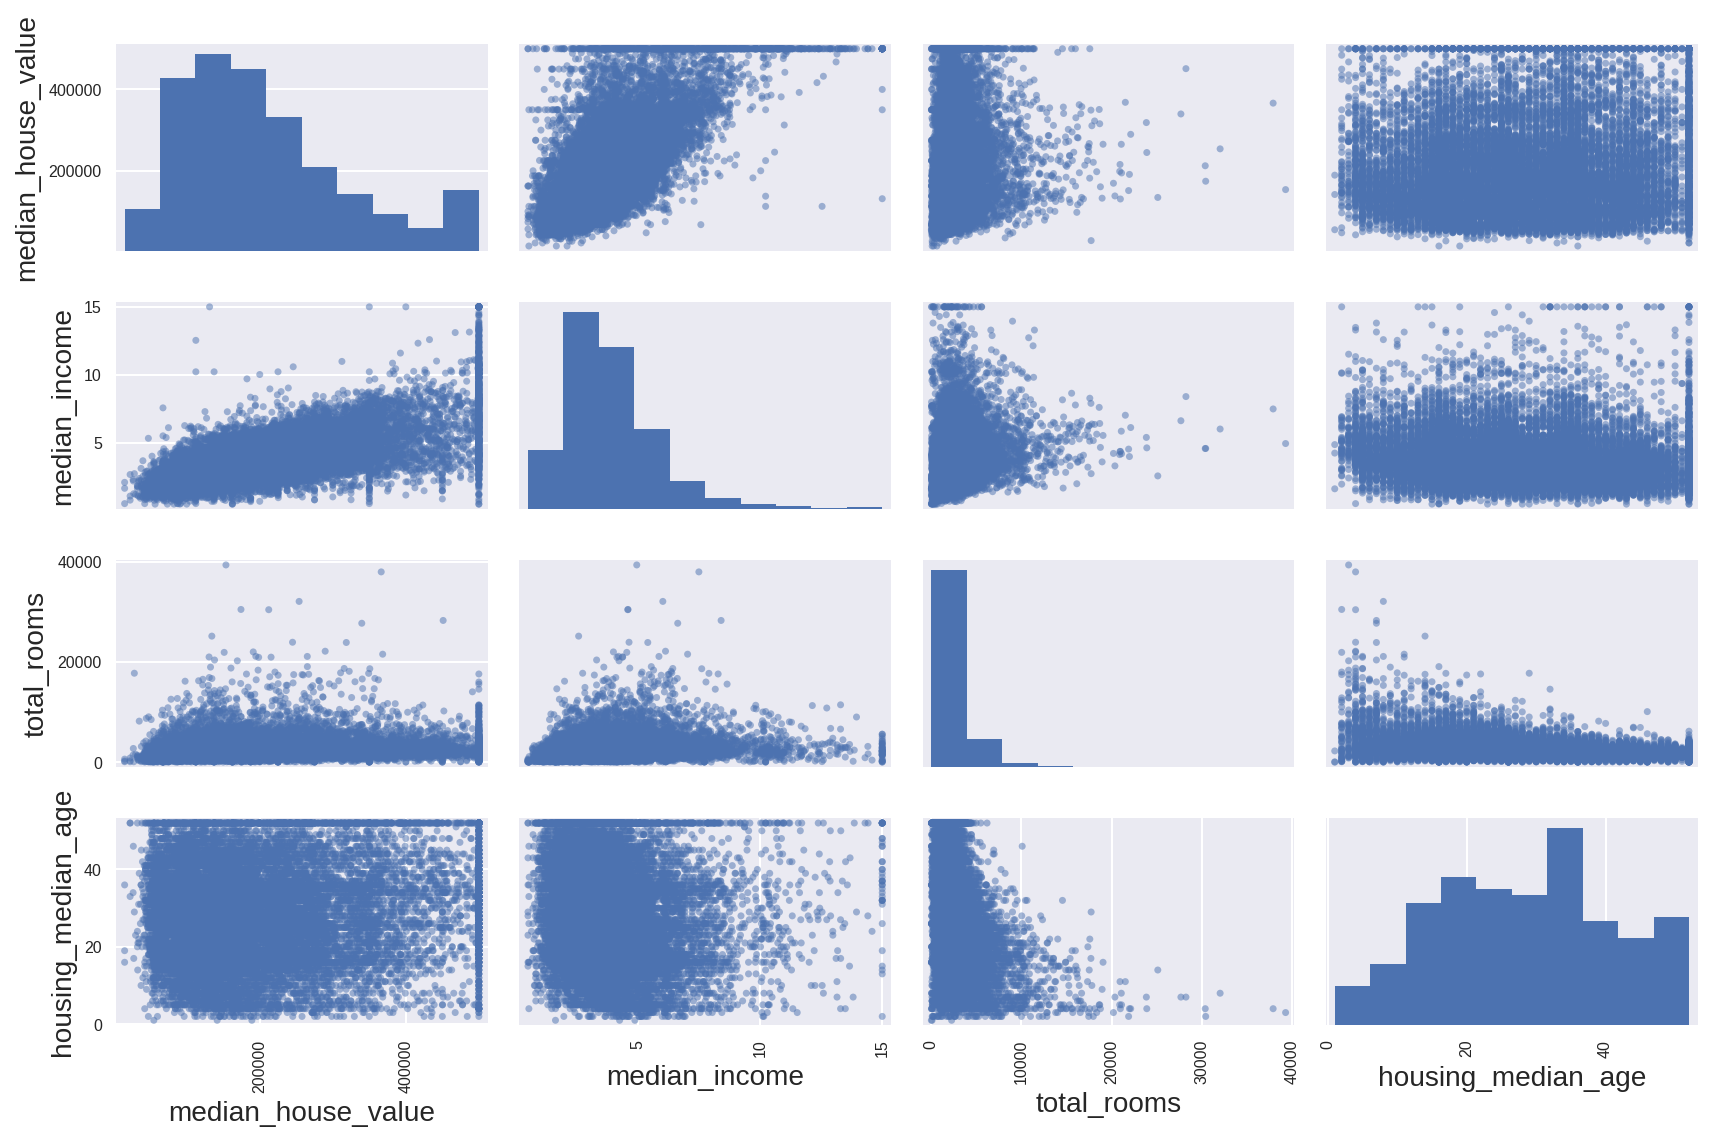

In [0]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
# save_fig("scatter_matrix_plot")
plt.tight_layout()

메인 대각선(왼쪽 위에서 오른쪽 아래)에는 각 속성에 대한 히스토그램을 보여줍니다. 이는 동일 속성에 대해 상관관계를 보여주는 것은 의미가 없기 때문입니다. 

중간 집값과 가장 상관관계가 높은 속성은 중간 소득입니다. 그 상관관계 산포도를 확대해 보도록 합시다. 

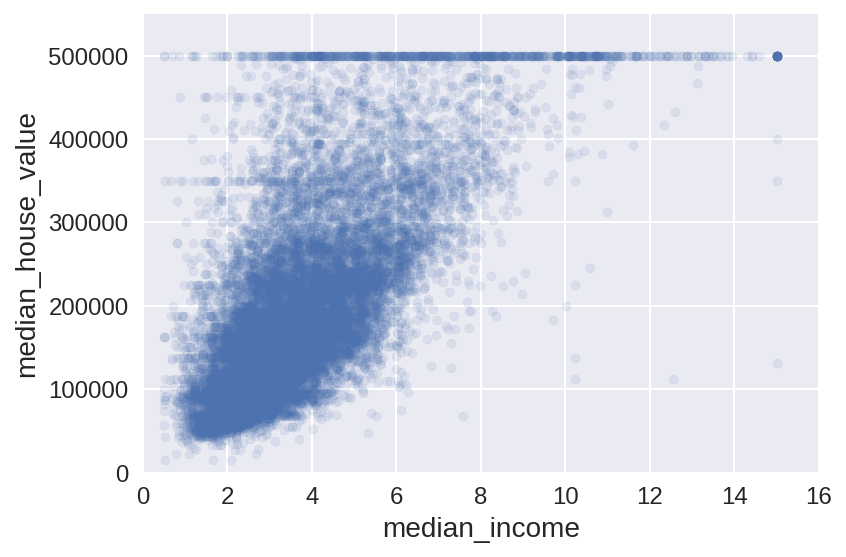

In [0]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
# save_fig("income_vs_house_value_scatterplot")
plt.tight_layout()

이 플롯은 몇가지를 나타냅니다.
첫째, 실제 상관관계가 매우 강하다는 것입니다: 상향 트렌드를 분명하게 볼 수 있고, 포인트들이 많이 분산되지도 않았습니다.
둘째, 처음에 알고 있던 가격 상한선이 $500,000 수평선에 분명하게 보입니다. 하지만, 이 플롯은 또 다른 분명한 직선들을 보여줍니다: $450,000 주변 수평선, $350,000 주변 수평선, 아마도 $280,000 주변 수평선과 다 아래의 일부.
이러한 데이터 단점을 재현하도록 알고리즘이 학습되는 것을 방지하기 위해 대응하는 지구를 제거해야 할지도 모릅니다.

## 속성 조합으로 시험하기


잘하면 이전 섹션의 몇가지 방법을 통해 데이터를 탐색한 후 인사이트를 얻을 수 있습니다. 

머신러닝 알고리즘에 데이터를 피딩(feed)하기 전에 청소하고 싶어할 몇가지 데이터 단점을 알게 되었습니다. 그리고 타겟 속성과 다른 속성들 사이의 흥미로운 상관관계를 발견했습니다 또한 몇몇 속성들은 편향된 분포도를 가지고 있다는 것을 알 수 있었고, 이것들을 변환(예, 그 속성들의 로그를 계산해서 표준분포로)해야할지도 모릅니다. 물론, 각 프로젝트마다 수고해야 하는 노고는 각기 다릅니다만, 일반적인 아이디어는 유사합니다.

**머신러닝 알고리즘을 위해 데이터를 실제 준비하기 전에 해야할 마지막 일은 다양하게 속성 조합을 시도해보는 것입니다**. 
예를 들어, 얼마나 많은 가정이 있는지 알지 못한다면, 각 지구의 전체 방수는 유용하지 않습니다. 정말 원하는 것은 각 가정의 방수입니다. 유사하게, 전체 침실수 자체로는 유용하지 않습니다. 아마도 침실수를 방숫자와 비교하고 싶어할 것입니다. 그리고 각 가정별 인구수 역시 흥미로운 속성 조합처럼 보입니다. 이들 새로운 속성들을 만들어 보도록 합시다. 


In [0]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


그런 다음, 다시 상관관계 매트릭스를 보도록 합시다:

In [0]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

새로운 bedrooms_per_room 속성이 중간 집값과  가장 높은 상관관계를 보여줍니다. 분명히 더 적은 침실/전체방 비율을 가진 집들이 더 비싼 경향이 있습니다. 각 가정별 방수 또한 지구내 전체 방수보다 더 많은 정보를 제공합니다- 분명히 집들이 더 클수록 더 비쌉니다.

이 라운드의 탐색은 아주 철저하지 않아도 됩니다; 포인트는 올바른 출발점을 찾는 것이고 합리적으로 좋은 프로토타입을 얻기 위한 인사이트를 빠르게 얻는 것입니다. 하지만 이것은 반복적인 절차입니다; 한번 프로토타입을 얻어서 실행한 후, 더 많은 인사이트를 얻기 위해 그 결과물을 분석할 수 있습니다. 그런 다음 이 탐색 단계로 다시 돌아올 수 있습니다. 

# 4. 기본 데이터 패턴을 머신러닝 알고리즘에 더 잘 노출할 수 있도록 데이터 준비하기


머신러닝 알고리즘을 위한 데이터를 준비할 시간입니다. 이것을 수동으로 하는 대신에, 자동으로 생성할 함수들을 사용해야 합니다.

그 이유는 다음과 같습니다.


*   어떤 데이터셋이든(예, 다음번에 새로운 데이터셋을 얻게 되었을 때), 이들 변환을 쉽게 재적용할 수 있도록 해줍니다.
*   미래의 프로젝트에서 재사용할 수 있는 변환 함수 라이브러리를 만들 수 있습니다.
*   이들 함수들을 알고리즘에 피딩하기 전에 새로운 데이터를 변환하기 위해 실제 사용하는 시스템에서 사용할 수 있습니다.
*   다양한 변환을 쉽게 시도하고 어떤 변환 조합이 가장 잘 동작하는지 알 수있도록 해줍니다.


이제 트레이닝 셋을 클리닝하기 위해 되돌려봅시다(다시 한번 strat_train_set을 복사하면 됩니다). 그리고 불필요하게 예측변수와 목표 값들에 동일한 변환이 적용되기를 원하지 않기 때문에 예측뼌수와 레이블을 분리하도록 합시다. 
(drop()이 데이터 복사본을 만들고, strat_train_set에는 영향을 주지 않는 것에 주의하시기 바랍니다.)





In [0]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## 데이터 클리닝

대부분의 머신러닝 알고리즘은 누락된 값이 있는 피처들(features)로는 작업할 수 없습니다. 따라서, 그것들을 다루기 위한 몇가지 함수들을 만들어 봅시다. 전 단계에서 total_bedrooms 속성에 누락된 값들이 있다는 것을 보았습니다. 이것을 고쳐보도록 합시다. 
다음의 3가지 옵션을 선택할 수 있습니다.


*   상응하는 지구(districts)를 제거합니다.
*   전체 속성을 제거합니다.
*   값들을 특정 값으로 설정합니다(제로, 평균, 중앙값 등).

이것들을 DataFrame의 dropna(), drop(), 그리고 fillna() 메서들 사용해 쉽게 처리할 수 있습니다.






In [0]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [0]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [0]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [0]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


만약 옵션 3을 선택한다면, 트레이닝 셋에 대한 중앙값을 계산해야만 합니다. 그리고 트레이닝 셋의 누락된 값들에 이것을 적용해야 합니다.
하지만, 위 코드처럼 계산했던 중앙값을 저장하는 것을 잊지 말아야 합니다.
나중에 시스템을 평가하고 싶을 때, 테스트 셋에서 누락된 값들을 대체하는 것이 필요할 것입니다. 그리고, 시스템을 운영한 후에는 신규 데이터에서 누락된 값들을 즉석에서 대체해야 합니다. 

[결측치 처리 (Imputer)](https://wikidocs.net/21276)

[데이터 전처리 및 정제의 중요성](https://statkclee.github.io/ml/14-ml-data-munging.html)

In [0]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

중앙값은 수치 속성들에 대해서만 계산될 수 있기 때문에, 텍스트 속성의 ocean_proximity를 제외한 데이터의 복사본을 생성하는 것이 필요합니다.

In [0]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

이제 fit() 메서드를 사용해 트레이닝 데이터에 imputer 인스턴스를 적용할 수 있습니다. 

In [0]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

imputer는 간단하게 각 속성의 중앙값을 계산하고, 그 결과를 statistics_ 인스턴스 변수에 저장합니다.
total_bedrooms 속성만이 누락된 값이 있지만, 이 시스템이 실제 운용되었을 때 신규 데이터에 어떤 누락된 값들이 있을지 확신할 수 없을 것입니다. 그래서 모든 수치 속성들에 대해 imputer를 적용하는 것이 더 안전합니다. 

In [0]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [0]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

이제 학습된 중앙값으로 누락된 값들을 대체함으로써 트레이닝셋을 변환하기 위해 "훈련된" imputer를 이용할 수 있습니다.

In [0]:
X = imputer.transform(housing_num)

결과물은 변환된 피쳐들(features)을 포함한 평이한 넘파이(NumPy)배열입니다. 판다스(Pandas) DataFrame으로 다시 넣고 싶다면, 간단히 처리할 수 있습니다.

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

## 텍스트 다루기와 범주 속성들

[Scikit-Learn의 전처리 기능](https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/)

[단어를 정수로 변환](https://wikidocs.net/21282)



앞에서 범주 속성인 ocean_proximity를 제외했습니다.
그 이유는 텍스트 속성이기 때문에 중앙값을 계산할 수 없기 때문입니다.
대부분의 머신러닝 알고리즘은 숫자를 가지고 작업하는 것을 선호합니다.
그렇기 때문에 이들 텍스트 라벨을 숫자로 변환해봅시다. 
사이킷 런(Scikit-Learn)은 이 작업에 필요한 LabelEncoder라 불리는 변환기를 제공합니다. 

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
housing_cat=housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

이러면 더 좋아집니다: 이제 어떤 ML 알고리즘에서도 이 숫자 데이터를 사용할 수 있습니다.
이 인코더가 classses_ 속성을 사용하여 학습한 매핑을 볼 수 있습니다.('<1H OCEAN'이 0에 매핑되었고, 'INLAND'이 1에 매핑되었습니다.)

In [0]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


위 인코더로 처리한 데이터의 한가지 이슈는 ML 알고리즘이 두개의 근접한 값들이 거리가 있는 두개의 값들보다 더 유사하다고 가정한다는 것입니다. 
분명히 이것은 그런 경우가 아닌데 말입니다(예를 들어, 범주 0과 4가 범주 0과 1보다 더 유사합니다).
이  이슈를 수정하기 위한, 일반적인 솔루션은 각 범주에 대한 하나의 바이너리 속성을 생성하는 것입니다: 범주가 '<1H OCEAN' 일 대 하나의 속성은 1과 같습니다(그렇지 않으면 0). 범주가 'INLAND'일 때 또 다른 속성이 1과 같습니다(그렇지 않으면 0) 등등. 
이것을 원-핫 인코딩이라 부릅니다. 범주들을 원-핫 벡터들로 인코딩합시다.
fit_transform()은 2D 배열을 기대하지만, housing_cat_encoded는 1D 배열이라는 것을 주의하시기 바랍니다.
그래서 이것을 재구성하는 것이 필요합니다. ****

In [0]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

산출물이 NumPy 배열이 아니라 SciPy 스파스(sparse) 매트릭스인 것에 유의하시기 바랍니다.
이것은 수천 개의 범주들을 가진 범주 속성을 가질 때 매우 유용합니다.
원-핫 인코딩 후, 수천개의 컬럼을 가진 매트릭스를 얻었습니다.
그리고 그 매트릭스는 각 열마다 하나의 1을 가진 것 말고는 0으로 가득합니다. 엄청난 메모리를 0으로 저장하는데 사용하는 것은 매우 비효율적입니다. 
그래서 대신 스파스(sparse) 매트릭스는 오직 0이 아닌 요소들의 위치만 저장합니다. 대개 일반적인 2D 배열처럼 사용할 수 있습니다. 하지만 정말 NumPy 배열로 전환하고 싶다면, toarray() 매서드를 호출하기만 하면 됩니다.

In [0]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

LabelBinarizer 클래스를 사용해서 (텍스트 범주에서 숫자 범주로 바꾸고, 숫자 범주에서 원-핫 벡터로 바꾸는 두 개의 변환을 한번에 적용할 수 있습니다.)

In [0]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

기본적으로 고밀도 NumPy 배열을 돌려준다는 것에 유의하시기 바랍니다.
sparse_output=True를 LabelBinarizer 컨스트럭터(constructor)를 전달함으로써 스파스(sparse) 매트릭스를 얻을 수 있습니다.

## 사용자 정의 트랜스포머(Transformers)

사이킷런 (Scikit-Learn)이 많은 유용한 트랜스포머(Transformer)를 제공하지만, 사용자 정의 클린업 또는 특정 속성들을 결합하는 것과 같은 작업을 위해 자신만의 트랜스포머를 작성하는 것이 필요할 것입니다.
사이킷런(Scikt-Learn)의 기능들(pipelines과 같은)을 가지고 완벽하게 작동하는 자신만의 트랜스포머를 원할 수 있습니다. 
사이킷런(Scikit-Learn)이 덕 타이핑(상속이 아닌)에 의존하기 때문에, 클래스를 생성하고 3개의 메서드 구현하는 것이 필요한 전부입니다: fit(), transform(), 그리고 fit_transform().간단히 기본 클래스로써 TranformerMixin을 추가함으로써 무료로 하나를 얻을 수 있습니다.
또한 기본 클래스로 BestEstimator를 추가한다면(컨스트럭터(constructor)에 *args와  *kargs를 피하세요), 자동 하이퍼파라미터를 조율하는데 유용한 두개의 특별 메서드(get_params()와 set_params())를 얻을 수 있습니다.
예를 들어, 아래 코드는 앞에서 논의한 결합된 속성들을 추가하는 작은 트랜스포머(transformer)클래스입니다.

*컴퓨터 프로그래밍 분야에서 덕 티이핑(duck typing)은 동적 타이핑의 한 종류로, 객체의 변수 및 메소드의 집합이 객체의 타입을 결정하는 것을 말합니다. 

[클래스 __init__이란?](https://edu.goorm.io/learn/lecture/202/%EB%B0%94%EB%A1%9C-%EC%8B%A4%ED%96%89%ED%95%B4%EB%B3%B4%EB%A9%B4%EC%84%9C-%EB%B0%B0%EC%9A%B0%EB%8A%94-%ED%8C%8C%EC%9D%B4%EC%8D%AC/lesson/26675/%ED%81%B4%EB%9E%98%EC%8A%A4-init-%EC%9D%B4%EB%9E%80)



 __init__ 은 클래스의 생성자입니다. self 매개 변수는 객체의 인스턴스를 참조합니다

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [0]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


이 예에서, 트랜스포머(transformer)는 기본적으로 True를 설정한(흔히 민감한 기본값을 제공하는데 도움이 됨), 하나의 하이퍼파라미터, add_bedrooms_per_room를 가지고 있습니다.
이 하이퍼 파라미터는 이 속성을 추가하는 것이 머신러닝 알고리즘에 도움이 되는지 안되는지 쉽게 찾을 수 있도록 해줄 것입니다. 
더 일반적으로, 100% 확신할 수 없는 어떤 데이터를 준비하는 단계에서 점검하기 위한 하이퍼파라미터를 추가할 수 있습니다. 
이들 데이터의 준비 단계를 더 많이 자동화하고, 자동화를 시도할 수  있는 결합을 더 많이 할 수록, 매우 좋은 결합을 발견할 가능성이 매우 높아질 것입니다(그리고 많은 시간을 절약하게 해 줄것입니다).

## 피처(Feature) 스케일링(Scaling)

데이터에 적용이 필요한 가장 중요한 변환 중 하나는 피처(feature) 스케일링(scaling)입니다. 
몇 가지 예외가 있지만, **머신러닝 알고리즘은 입력 수치 속성들이 매우 다른 스케일링을 가지면 잘 수행되지 않습니다.**
housing 데이터가 그런 경우입니다: 중간 소득이 0에서 15까지의 범위를 가지는 것에 비해, 전체 방수는 6에서 39,320까지의 범위를 가집니다. 
**목표값의 스케일링은 일반적으로 필요하지 않다**는 것에 유의하시기 바랍니다.
모든 속성들이 동일한 스케일을 갖도록 하는 두가지 일반적인 방법이 있습니다: min-max scaling과 standardization.
**Min-max scaling**(많은 사람들이** normalization**이라 부릅니다)은 매우 간단합니다: 값들이 이동되어, 결국 **0에서 1 사이의 범위**에서 재스케일링됩니다. 최소값을 뺀 값에, 최대값에서 최소값을 마이너스한 값을 나눔으로써 구합니다.


$x_{new} = \frac{x-x{min}}{x_{max}-x_{min}}$


사이킷런 (Scikit-Learn)에서는 이를 위해 MinMaxScaler라는 트랜스포머를 제공합니다.
어떤 이유로 **0-1의 범위를 원하지 않을 때 범위를 변경할 수 있도록 feature_range라는 하이퍼트랜스포머를 갖습니다.**

**표준화(Stnadardization)**는 전혀 다릅니다: 먼저 평균값을 구합니다(그래서 표준화된 값은 항상 제로 평균값을 갖습니다). 그런 다음 분산으로 나누어, 그 결과 분포가 단위 분산을 갖도록 합니다.

$x_{new} = \frac{x-\mu}{\sigma}$

**min-max scaling과 달리, 표준화(standardization)는 값을 특정 범위로 한정하지 않습니다.**
**이것이 몇몇 알고리즘에서는 문제가 될 수도 있습니다**(예를 들어, 뉴럴 네트워크는 흔히 입력 값의 범위를 0에서 1이라고 기대합니다). 하지만, **표준화(standardization)는 특이값(outliers)에 의한 영향을 훨씬 덜 받습니다.**
예를 들어, 한 지구(district)의 중간 소득이 100과 같다고 (실수로) 가정합시다. Min-max scaling은 모든 다른 값들이 0-15에서 0-0.15로 망가트립니다. 반면세 표준화(Standardization)는 별로 영향을 받지 않습니다.
사이킷런(Scikit-Learn)은 표준화(Standardization)를 위해 **StandardScaler**라는 트랜스포머를 제공합니다.


## 변환 파이프라인(Pipeline)

보시다시피, 올바른 순서로 실행해야 하는 데이타 변환의 많은 단계가 있습니다. 사이킷런(Scikit-Learn)은 그러한 일련의 변환을 도와줄 수 있는 파이프라인(Pipeline) 클래스를 제공합니다.
수치 속성들에 대한 작은 파이프라인 코드를 보시기 바랍니다.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr=num_pipeline.fit_transform(housing_num)

In [0]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [0]:
from future_encoders import OneHotEncoder

In [0]:
from future_encoders import ColumnTransformer
# from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

**파이프라인(Pipeline) 생성자(constructor)는 일련의 단계를 정의하는 이름(name)/추정량(estimator) 쌍 리스트를 가집니다.**
마지막 추정량을 제외한 모든 것이 트랜스포머야 합니다. (예, 그것들은 fit_transform() 메서드를 가져야만 합니다). 
이름들(names)은 좋아하는 어떤 것으로도 정할 수 있습니다.
파이프라인의 fit() 메서드를 호출할 때, 마지막 추정량에 도달할 때까지, 파라미터로써 각 호출의 결과물을 다음 호출에 전달합니다. 
모든 트랜스퍼머에 대해 순차적으로 fit_transform()을 호출하며, 이를 위해서 fit() 메서드를 호출하기만 하면 됩니다. 
파이프라인은 마지막 추정량으로써 동일한 메서드를 제공합니다. 마지막 추정량은 StandardScaler입니다. 
이것은 트랜스포머이기 때문에 파이프라인은 순차적으로 데이터에 모든 변환을 전달하는 transform() 메서드를 가집니다(또한 fit()과 함께 transform()을 호출하는 대신에 사용했던 fit_transform 메서드를 가집니다).
이제 수치 값들에 대한 파이프라인을 가지게 되었습니다. 그리고 LabelBinarizer를 범주 값들에 대해 적용하는 것이 필요합니다: 이러한 변환을 어떻게 단일 파이프라인에 결합시킬 수 있을가요? 사이킷런(Scikit-Learn)은 이것을 위해 **FeatureUnion 클래스**를 제공합니다. 변환리스트를 제공하고(전체 변환 파이프라인이 될 수 있습니다), transform() 메서드가 호출되었을 때 각각의 변환에 대한 transfrom() 메서드가 병행으로 실행됩니다.
결과물을 기다린 후, 그것들을 결합하고 결과값으로 돌려줍니다.
수치와 범주 속성 양쪽을 핸들링하는 전체 파이프라인은 다음처럼 보여질 수 있습니다.

각 서브 파이프라인은 선택기(selector) 파이프라인으로 시작합니다: 간단히 원하는 속성(수치 또는 범주)을 선택함으로써 데이터를 변환합니다.
나머지를 버리고, 결과 DataFrame을 넘파이(NumPy) 배열로 전환합니다. 
사이킷런(Scikit-Learn)에서는 판다스(Pandas) DataFrame을 핸들링할 수 없기 때문에, 이 작업을 위해 간단한 사용자 정의 트랜스포머를 작성하는 것이 필요합니다.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [0]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [0]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [0]:
from sklearn.pipeline import FeatureUnion

In [0]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

그리고 전체 파이프라인을 간단하기 실행할 수 있습니다:

In [0]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
housing_prepared.shape

(16512, 16)

In [0]:
!ls

california.png	datasets  future_encoders.py  __pycache__  sample_data


# 5. 다양한 모델을 탐색하고 그 중 가장 좋은 모델 찾기

지금까지 문제를 정의하고, 데이터를 얻어서 탐색해 보았습니다. 

그리고 트레이닝 셋과 테스트 셋을 샘플링하고, 자동적으로 머신러닝 알고리즘을 위해 클리닝해서 데이터를 준비하기 위해 변형 파이프라인을 작성했습니다.

이제 머신러닝 모델을 선택해서 트레이닝시킬 준비가 되었습니다. 

## 트레이닝 셋에서 훈련하고 평가하기

좋은 소식은 이전 1~4단계 덕분에, 이제 생각했던 것보다 상황이 훨씬 간단하게 진행될 것이라는 점입니다. 
우선 선형 회귀 모델을 트레이닝해 봅시다.

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

다 했습니다!
이제 선형 회귀 모델을 사용할 수 있습니다.
트레이닝 셋으로부터 몇 가지 인스턴스를 시도해 보도록 하겠습니다:

In [0]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [0]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


예측이 아주 정확하지는 않지만 작동합니다
(두번째 예측이 50% 이상 차이가 있습니다!).
사이킷런(Scikit-Learn)의 mean_squared_error 함수를 사용해서 전체 트레이닝 셋에 대한 이 회귀 모델의 RMSE를 측정해 봅시다.

In [0]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

이제, 좀 나아졌습니다.
하지만 아직 좋은 점수를 받을 정도는 아닙니다: 가장 큰 지구(district)의 median_housing_values의 범위는 120,000 달러ㅓ에서 265,000 달러 사이입니다.
따라서 68,628 달러의 전형적인 예측 에러는 아주 만족스럽지 못합니다.
이것이 트레이닝 데이터의 **과소적합(underfitting)**된 모델의 사례입니다.
이런 일이 일어나면, 훌륭한 예측을 만들어 내기 위해 **피처들(features)이 충분한 정보를 제공하지 않았다**는 것 또는 **이 모델이 충분히 파워풀하지 않다**는 것을 의미할 수 있습니다.
앞의 단계에서 보았듯이, 과소적합(underfitting)을 수정하기 위한 주요 방법은 더욱 강력한 모델을 선택하고, 더좋은 피쳐들(features)을 가진 트레이닝 알고리즘을 먹이는 것입니다. 또는 이 모델에 대한 제약을 줄이는 것입니다. 이 모델은 정규화되지 않았기 때문에, 이 규칙들은 마지막 옵션에서 제외됩니다. 더 많은 피쳐들(features)을 추가하는 것(예를 들어, 인구의 로그)을 시도해 볼 수 있습니다. 하지만 **먼저 보다 복잡한 모델을 시도해 보도록 합시다.**
**DecisionTreeRegressor**을 훈련시켜 봅시다.
이것은 데이터에서 복잡한 비선형 관계를 찾아낼 수 있는 강력한 모델입니다.
코드가 이제 친숙해 보여야 할 것입니다:


In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

자, 이 모델이 훈련되었고, 트레이닝 셋에서 이 모델을 평가해 보도록 합시다:

In [0]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

잠깐, 뭘까요? 아무런 에러도 없었습니다. 정말 이 모델이 완벽한 걸까요?
물론, 이 모델이 이 데이터에 과적합(overfitting)했을 가능성이 훨씬 높습니다. 
어떻게 확신할 수 있을까요?
앞에서 보았듯이, 만족스러운 모델을 런칭할 준비가 될 때까지 테스트 셋을 만지는 것을 원하지 않을 것입니다. 
그래서 트레이닝 셋 일부를 훈련용으로 사용하고, 일부는 모델 검증용으로 사용하는 것이 필요합니다.

## 교차검증(Cross-Validation)을 사용해 더 좋은 평가 만들기 

결정트리(Decision Tree) 모델을 평가하기 위한 한가지 방법은 트레이닝 셋을 더 작은 트레이닝 셋과 더 작은 트레이닝 셋과 검증 셋으로 구분하기 위해** train_test_split 함수**를 사용하는 것일 겁니다. 그후 더 작은 트레이닝 셋을 모델을 훈련시키고 검증 셋에 대해 검증을 실시합니다. 약간의 작업이 있긴 하지만, 그다지 어렵지 않고 잘 작동할 것입니다.
훌륭한 대안은 사이킷런(Scikit-Learn)의 **교차검증(cross-validation) **기능을 이용하는 것입니다. 
다음의 코드는 **K-fold 교차검증(cross-validation)**을 실행합니다: 무작위로 folds라 불리는 10개 단위의 서브셋으로 트레이닝 셋을 분리합니다. 
그 다음 결정트리(Decision Tree)모델로 10번 훈련시키고 평가합니다. 
매번 평가를 위해 다른 fold를 골라내고 또 다른 9개 folds를 훈련시킵니다.
그 결과는 10개의 평가 점수를 포함한 배열로 나타납니다.

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

(주의) 사이킷런(Scikit-Learn)의 교차검증(cross-validation) 기능은 코스트 함수(작을수록 더 좋은)가 아닌 유틸리티 함수(클수록 더 좋은)를 기대합니다.
그래서 **스코어링 함수**는 실제로 MSE와 반대(앞의 코드처럼 계산된 이유-제곱근을 계산하기 전의 값)입니다.

결과를 보도록 합시다:

In [0]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70232.0136482  66828.46839892 72444.08721003 70761.50186201
 71125.52697653 75581.29319857 70169.59286164 70055.37863456
 75370.49116773 71222.39081244]
Mean: 71379.07447706361
Standard deviation: 2458.3188204349362


지금 결정트리(Decision Tree)가 앞에서 했던 것보다 좋아 보이진 않습니다.
사실, 선형 회귀 모델보다 더 나쁘게 수행하는 것처럼 보입니다!
교차검증(cross-validation)이 당신 모델의 성능을 검증하는 것뿐만 아니라 이 검증이 얼마나 정확한지 측정하는 것(예., 표준편차) 역시 수행하고 있다는 것에 유념하시 바랍니다.
이 결정트리(Decision Tree)는 정확히, 일반적으로 $\pm 3200$의 편차를 갖는, 71,200의 점수를 받았습니다.
하나의 검증 셋만을 사용한다면, 이런 정보를 가질 수 없습니다. 하지만, 교차검증(cross-validation)은 몇 번에 걸쳐 모델을 훈련시키는 비용이 따르기 때문에 항상 가능하지는 않습니다.
선형 회귀 모델을 확인해 보기 위해 동일한 점수를 계산해 보도록 합시다:

In [0]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


맞습니다: 결정트리(Decision Tree) 모델이 과적합(overfitting)되었습니다. 
그래서 슬프게도 선형 회귀 모델보다 안좋은 성능을 발휘합니다.
이제 마지막 남은 모델을 시도해 보도록 합시다: **RandomForestRegressor.** 랜덤 포레스트(Random Forest)는 예측값을 평균화하는 대신 피쳐들(features)의 무작위 서브셋을 많은 결정트리(Decision Trees)로 훈련시켜 작동합니다.
많은 다른 모델들의 최고 위에 모델을 세우는 것을 **앙상블 학습(Ensemble Learning)**이라 부릅니다. ML 알고리즘을 더욱 발전시키기 위한 좋은 방법입니다. 


In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [0]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51650.94405471 48920.80645498 52979.16096752 54412.74042021
 50861.29381163 56488.55699727 51866.90120786 49752.24599537
 55399.50713191 53309.74548294]
Mean: 52564.19025244012
Standard deviation: 2301.873803919754


이제 더 좋아졌습니다: 랜덤 포레스트(Random Forest)가 더 유망해 보입니다. 하지만, 검증셋보다 트레이닝 셋의 점수가 여전히 더 낮다는 것에 유념하시기 바랍니다. 
이것은 이 모델이 여전히 트레이닝 셋에 과적합(overfitting)되어 있다는 것을 의미합니다. 
과적합(overfitting)에 있어 가능한 해결책은 모델을 단순화하고, 제약을 가하거나 (예, 정규화하는 것), 더 많은 훈련 데이터를 얻는 것입니다. 
하지만, 랜덤 포레스트(Random Forests)에 더 깊이 들어가기 전에, 하이퍼파라미터를 조율하는 데 너무 많은 시간을 소비하지 않고, 다양한 범주의 머신러닝 알고리즘으로부터 많은 다른 모델들을 시도해 보아야 할 것입니다.
목표는 몇 가지(2-5개의) 유망한 모델을 선정하는 것입니다.

# 6. 모델을 알맞게 튜닝하고 멋진 솔루션으로 통합하기

이제 유망한 모델들을 가졌다고 가정해 봅시다. 
그럼 이 모델들을 튜닝하는 것이 필요합니다.
실행할 수 있는 몇가지 방법을 살펴보도록 하겠습니다.

## 그리드 서치 (Grid Search)

모델 튜닝을 수행하는 한 가지 방법은 하이퍼파라미터 값들의 좋은 조합을 찾아낼 때까지, 수동으로 하이퍼파라미터(hyperparameters)를 사용하는 것입니다.

이것은 매우 지루한 작업이 될 것이고, 많은 조합을 탐색할만한 시간을 갖고 있지 않을 수도 있습니다.
그 대신에, 사이킷런(Scikit-Learn)의 **GridSearchCV**로 탐색을 하도록 할 수 있습니다.
해야 할 일 전부는 어떤 하이퍼파라미터를 실험하고 싶은지, 어떤 값들을 시험해 보아야 하는지를 알려주는 것입니다.
그러면, 교차검증(cross-validation)을 사용해, 하이퍼파라미터 값들의 모든 가능한 조합들을 평가할 것입니다.
예를 들어, 다음의 코드는 RandomForestRegressor를 위ㅓ해 하이퍼파라미터 값들에 대한 최상의 조합을 검색합니다.

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

팁) 하이퍼파라미터가 어떤 값을 가져야 할지 알 수 없을 때, 간단한 접근법은 연속적으로 10의 파워를 시도해보는 것입니다(또는 더 세분화된 탐색을 원한다면, 더 작은 숫자로 시도: n_estimators 하이퍼파라미터를 가진 위 예에서 보듯이)

위 param_grid는 사이킷런에게 처음에 n_estimators의 모든 $3\times 4=12$개의 조합과 첫번째 dict에서 특정한 max_features 하이퍼파라미터 값들을 평가하도록 알려줍니다.

그 다음에 두번째 dict인 모든 $2 \times 3 = 6$개의 하이퍼파라미터 값들의 조합을 시도합니다. 

하지만, 이번에는 bootstrap 하이퍼파라미터는 True(이 하이퍼파라미터의 기본값이 True임)대신에 False를 설정합니다.

전체적으로, 그리드 서치(grid search)는 RandomForestRegressor 하이퍼파라미터 값들의 $12+6=18개$ 조합들을 탐색할 것입니다. 

그리고 각 모델을 5번씩(왜냐하면 five-fold 교차검증을 사용하기 때문) 훈련시킬 것입니다. 

달리 말하자면 전체적으로,  $18 \times 5 = 90$번의 훈련 라운드가 될 것입니다.
아주 많은 시간이 걸리겠지만, 아래와 같이 최상의 파라미터 조합을 얻게 될 것입니다.

In [0]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

팁) n_estimators의 최대값이 30으로 평가되었습니다. 점수가 지속적으로 향상될 수도 있기 때문에, 더 높은 값도 평가해 보아야 할 것입니다.

직접 최상의 평가자(estimator)를 얻을 수도 있습니다.

In [0]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

물론 평가 점수들도 이용할 수 있습니다.

In [0]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63647.85444595992 {'max_features': 2, 'n_estimators': 3}
55611.50159876327 {'max_features': 2, 'n_estimators': 10}
53370.06407363344 {'max_features': 2, 'n_estimators': 30}
60959.138858487866 {'max_features': 4, 'n_estimators': 3}
52740.58416665252 {'max_features': 4, 'n_estimators': 10}
50374.14214614731 {'max_features': 4, 'n_estimators': 30}
58661.2866461823 {'max_features': 6, 'n_estimators': 3}
52009.973979776936 {'max_features': 6, 'n_estimators': 10}
50154.11777368494 {'max_features': 6, 'n_estimators': 30}
57865.36168014446 {'max_features': 8, 'n_estimators': 3}
51730.07550866553 {'max_features': 8, 'n_estimators': 10}
49694.85143334442 {'max_features': 8, 'n_estimators': 30}
62874.407393096284 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54643.49980834466 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59437.89228588419 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52735.358293621044 {'bootstrap': False, 'max_features': 3, 'n_estimators':

위 예에서, max_features 하이퍼파라미터를 6으로, n_estimators 하이퍼파라미터를 30으로 설정함으로써 최상의 해결책을 확보할 수 있습니다. 

이 조합의 RMSE 점수는 49,959입니다.

기본 하이퍼파라미터 값들(점수가 52,634)을 사용한 경우보다 더 좋은 점수를 얻었기 때문에 약간 더 좋아졌습니다. 
성공적으로 최상의 모델로 잘 튜닝했습니다!

팁) 하이퍼파라미터로 데이터 준비 단계 중 일부를 다룰 수 있다는 것을 잊지 마세요. 예를 들어, **그리드 서치(grid search)는 확신할 수 없는 피쳐(features)를 추가하는 것과는 상관없이 자동적으로 찾아낼 것입니다. 자동으로 간단히 아웃라이어 핸들링, 누락된 피쳐들, 피쳐 선택 등에 대한 최상의 방법을 찾을 수 있도록 사용될 수 있을 것입니다.**



## 무작위 서치(Randomized Search)

**그리드 서치(grid search) 접근법은** 앞의 예처럼, **상대적으로 적은 조합을 탐색할 때 좋습니다. **

하지만, 하이퍼파라미터 서치 스페이스가 클 때는, 그리드 서치 대신에 RandomizedSearchCV를 사용하는 것을 더 선호합니다.

이 클래스는 GridSearchCV 클래스와 매우 유사한 방법으로 사용할 수 있습니다.

하지만 모든 가능한 조합들을 시도하는 대신에, 매 반복시마다 각 하이퍼파라미터에 대해 랜덤한 값을 선택함으로써 주어진 숫자만큼 무작위 조합에 대해 평가합니다. 

이 접근법은 두가지 주요 혜택이 있습니다.


*   만약 1,000회 반복하도록 무작위 서치를 실행한다면, 이 접근법은 각각의 하이퍼파라미터에 대해 1,000 개의 다른 값들을 탐색할 것입니다.(그리드 서치 접근법에서는 각각의 하이퍼파라미터에 대해 단지 몇 개의 값들을 탐색)
*   간단히 반복할 숫자를 설정함으로써, 하이퍼파라미터 검색에 할당할 컴퓨팅 자원을 더 잘 컨트럴할 수 있습니다.



## 앙상블 메서드(Ensemble Methods)

시스템을 튜닝하기 위한 또 다른 방법은 가장 잘 수행할 수 있는 모델들을 결합시켜 보는 것입니다.

그 그룹(또는 '앙상블')은 최상의 개별 모델보다 더 잘 수행할 것입니다(랜덤 포레스트가 의지하는 개별 결정 트리 보다 랜덤 포레스트가 더 잘 수행하는 것과 같음).

특히, 개별 모델이 매우 다른 형태의 오류를 만드는 경우 더 그렇습니다.

## 최고의 모델과 그 모델의 에러 분석하기

가장 좋은 모델을 검사하여 문제에 대한 좋은 통찰을 얻을 수 있습니다.
예를 들어, RandomForestRegressor은 정확한 예측을 하기 위해, 각 속성의 상대적 중요성을 나타낼 수 있습니다.

In [0]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

해당 속성의 이름 옆에 중요도 점수를 표시합니다.

In [0]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
# cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

이 정보를 가지고, 유용하지 않은 피쳐들(features) 일부를 탈락시키고 싶을 수도 있습니다(예, 분명히 하나의 ocean_proximity 범주만이 정말 유요합니다. 그래서 다른 것들에 대한 탈락을 시도할 수 있습니다).

또한, 시스템에서 발생시키는 특정 에러를 살펴보아야만 합니다.

그런 다음, 발생 원인을 이해하도록 해야 하고, 그  문제를 어떻게 고칠 수 있는지도 이해해야 합니다(다른 피처들을 추가하거나 반대로  불필요한 피쳐들을 제거하고, 아웃라이를 클리닝하는 등)

## 테스트 셋에서 시스템 평가하기



잠시동안 모델을 조정한 후에, 결국 효율적으로 잘 수행하는 시스템을 갖게 되었습니다. 이제 최종 모델을 테스트셋에서 평가해볼 시간입니다.
이 프로세스에 있어 특별한 것은 없습니다: 단지 테스트셋에서 예측변수(predictors)와 레이블을 가져와, 데이터를 변환(fit_transform()이 아니라 transform()을 호출!)하기 위해 full_pipeline을 실행합니다. 그리고 테스트 셋에서 최종 모델을 평가합니다:

In [0]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

많은 하이퍼파라미터를 튜닝했다면, 성능은 보통 교차 검증(cross-validation)을 사용해 측정한 것보다 조금 나쁠 겁니다
(왜냐하면, 검증 데이터에서 잘 수행되도록 미세 조정되었기 때문에, 알려지지 않은 데이터셋에서는 잘 수행되지 않을 것입니다). **bold text**

이 예에서는 그렇지 않습니다만, 이런 경우가 생기면 **테스트 셋에서  숫자가 잘 나올 수 있도록 하이퍼파라미터를 조정하는 유혹에 빠지면 안됩니다:** 그 개선은 새로운 데이터에 일반화될 것 같지 않기 때문입니다. 

이제 프로젝트가 시작되는 시점이 되었습니다: 해결책을 제시하는 것(**학습한 것을 강조 표시하고, 무엇이 작동되고 무엇이 안되는지, 어떤 가정들이 만들어졌는지, 그리고 이 시스템의 한계는 무엇인지**), 모든 것을 문서화하고, 분명한 시각화와 쉽게 기억할 수 있는 문구를 가진 멋진 프레젠테이션을 만드는 것이 필요합니다(예, ' 중앙 소득은 주택 가격의 가장 중요한 예측 변수입니다')

# 7. 시스템 런칭, 모니터링과 유지하기

이제 제품화를 위한 솔루션 준비가 필요합니다.

특히, 제품을 가동함으로써 시스템에 데이터 소스를 입력하고 테스트를 작성하기 위한 준비가 필요합니다.

또한, 시스템을 정기적으로 실제 사용 중에 점검할 수 있는 모니터링 코드를 작성하는 것도 필요합니다. 

문제가 생기면 경고도 날려줘야 합니다.

이것은 갑작스런 작동중단 뿐 아니라, 성능 저하를 잡아내는 데 있어 중요합니다. 

모델은 정기적으로 새로운 데이터로 훈련되지 않으면, 시간이 지남에 따라 모델의 데이터가 "망가지는" 경향이 있기 때문에 매우 일반적입니다.

시스템의 성능을 평가하려면 시스템의 예측을 샘플링하고 그것들을 평가해야 합니다. 이것은 일반적으로 사람의 분석을 요구합니다. 이 분석가들은 현장 전문가일 수도 있고, 크라우드소싱 플랫폼의 작업자일수도 있습니다(Amazon Mechanical Turk 또는 CrowdFlower같은) 어느쪽이든, 사람의 평가 파이프라인을 시스템에 연결해야 합니다.

또한, 시스템의 입력 데이터 품질을 평가해야 합니다.

때때로 나쁜 품질 시그널(예, 오작동하는 센서가 무작위 값들을 보내거나, 다른 팀의 결과가 부실해지거나) 때문에, 성능이 약간씩 떨어질 것입니다.

하지만, 시스템 성능 저하에 따른 경고를 받기까지는 딜레이 시간이 걸릴 수 있습니다. 

만약 시스템의 입력을 모니터하고 있다면, 이 경고를 더 일찍 잡아낼 수 있습니다.

특히 입력 모니터링은 온라인 학습 시스템에서 중요합니다.


마지막으로 말할 것은, 일반적으로 새로운 데이터를 가지고 정기적으로 모델을 훈련시키는 것을 원할 것이라는 것입니다.
가능한 한 이 프로세스를 자동화해야 합니다.
그렇지 않으면, (적어도) 6개월마다 시스템을 고칠 가능성이 큽니다.
그리고 시스템 성능은 시간이 지남에 따라 크게 변동될 수 있습니다. 
만약 온라인 학습 시스템이라면, 일정한 간격으로 상태 스냅샷을 저장해야만 할 것입니다.
그렇게 해서, 쉽게 이전의 작동 상태로 되돌아갈 수 있습니다.